In [100]:
for split, condition in zip([4, 5, 3], ["full", "all_s3d", "no_kinematic"]):
    print(split)
    print(condition)

4
full
5
all_s3d
3
no_kinematic


Duplicate key in file 'C:\\Users\\FM\\Documents\\Akseli\\Code\\MovFormer\\configs_global\\style.mplstyle', line 10 ('font.size: 13')

Bad key text.fontsize in file C:\Users\FM\Documents\Akseli\Code\MovFormer\configs_global\style.mplstyle, line 16 ('text.fontsize: 10')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.6/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


4
C:\Users\FM\Documents\Akseli\Code\MovFormer\result\Freddy_feature_ablation_20251021_161907\split_4\test_results_epoch100.npy
full
5
C:\Users\FM\Documents\Akseli\Code\MovFormer\result\Freddy_feature_ablation_20251021_161907\split_5\test_results_epoch100.npy
all_s3d
3
C:\Users\FM\Documents\Akseli\Code\MovFormer\result\Freddy_feature_ablation_20251021_161907\split_3\test_results_epoch100.npy
no_kinematic
full Kin + CP + Top 20 S3D
all_s3d Kin + CP + All 1024 S3D
no_kinematic CP + Top 20 S3D


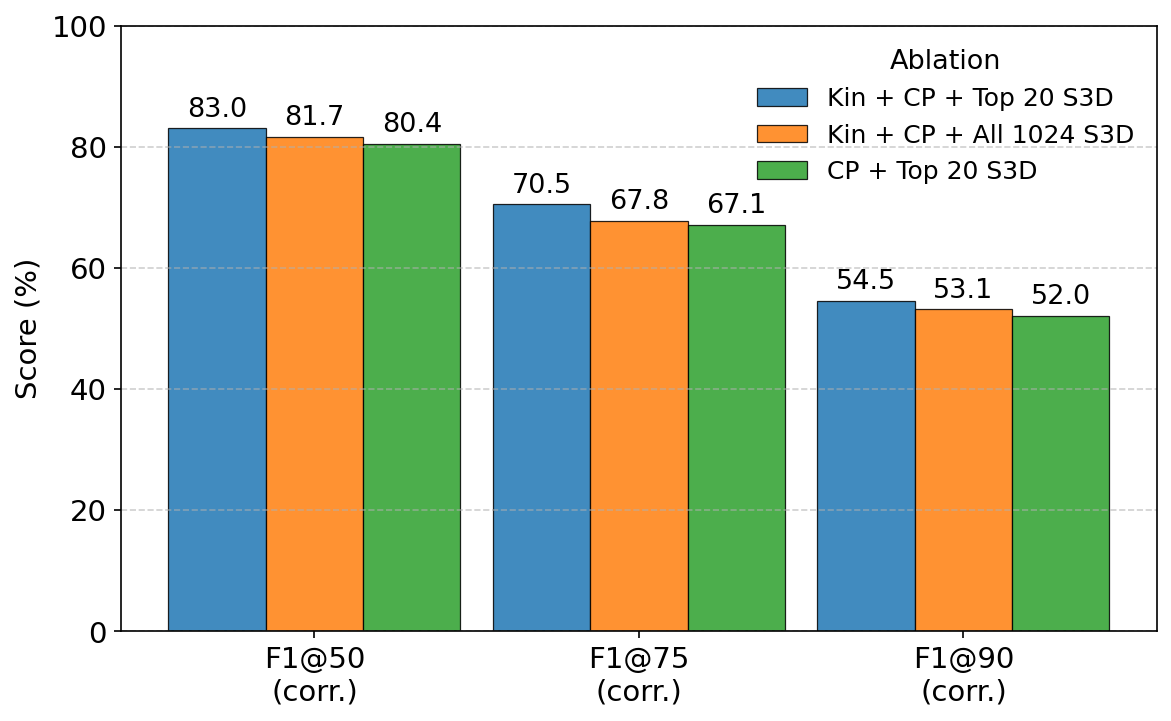

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = r"C:\Users\FM\Documents\Akseli\Code\MovFormer\configs_global\style.mplstyle"
plt.style.use(path)

key = "uncorrected"
agg_metrics = {}

for split, condition in zip([4, 5, 3], ["full", "all_s3d", "no_kinematic"]):

    path = f"C:\\Users\\FM\\Documents\\Akseli\\Code\\MovFormer\\result\\Freddy_feature_ablation_20251021_161907\\split_{split}\\test_results_epoch100.npy"
    data = np.load(path, allow_pickle=True).item()
    print(split)
    print(path)
    print(condition)
    agg_metrics[condition] = {
        'F1@50\n(corr.)': float(data["corrected"]['F1@50']),
        'F1@75\n(corr.)': float(data["corrected"]['F1@75']),
        'F1@90\n(corr.)': float(data["corrected"]['F1@90']),
    }


df = pd.DataFrame.from_dict(agg_metrics, orient='index')

# Plot setup
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(df.columns))
width = 0.3
colors = plt.cm.tab10.colors  # Nice modern palette


labels = ["Kin + CP + Top 20 S3D", "Kin + CP + All 1024 S3D", "CP + Top 20 S3D"]


# Plot bars for each condition
for i, condition in enumerate(df.index):
    print(condition, labels[i])
    
    offset = width * (i - len(df.index) / 2 + 0.5)
    bars = ax.bar(
        x + offset,
        df.loc[condition],
        width,
        label=labels[i],
        color=colors[i % len(colors)],
        alpha=0.85,
        edgecolor='black',
        linewidth=0.6
    )

    # Annotate values above bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom',
                    color='black')

# Style tweaks
ax.set_ylabel('Score (%)')
ax.set_xticks(x)
ax.set_xticklabels(df.columns)
ax.legend(title='Ablation', loc='upper right', frameon=False)
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig("C:\\Users\\FM\\Documents\\Akseli\\Code\\MovFormer\\movformer\\thesis_figures\\accel\\bar_plot.eps")

C:\Users\FM\Documents\Akseli\Code\MovFormer\movformer\eval\eval_plotting.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\FM\\Documents\\Akseli\\Code\\MovFormer\\movformer\\temp\\eval_summary_epoch40_20251102_152141.png'

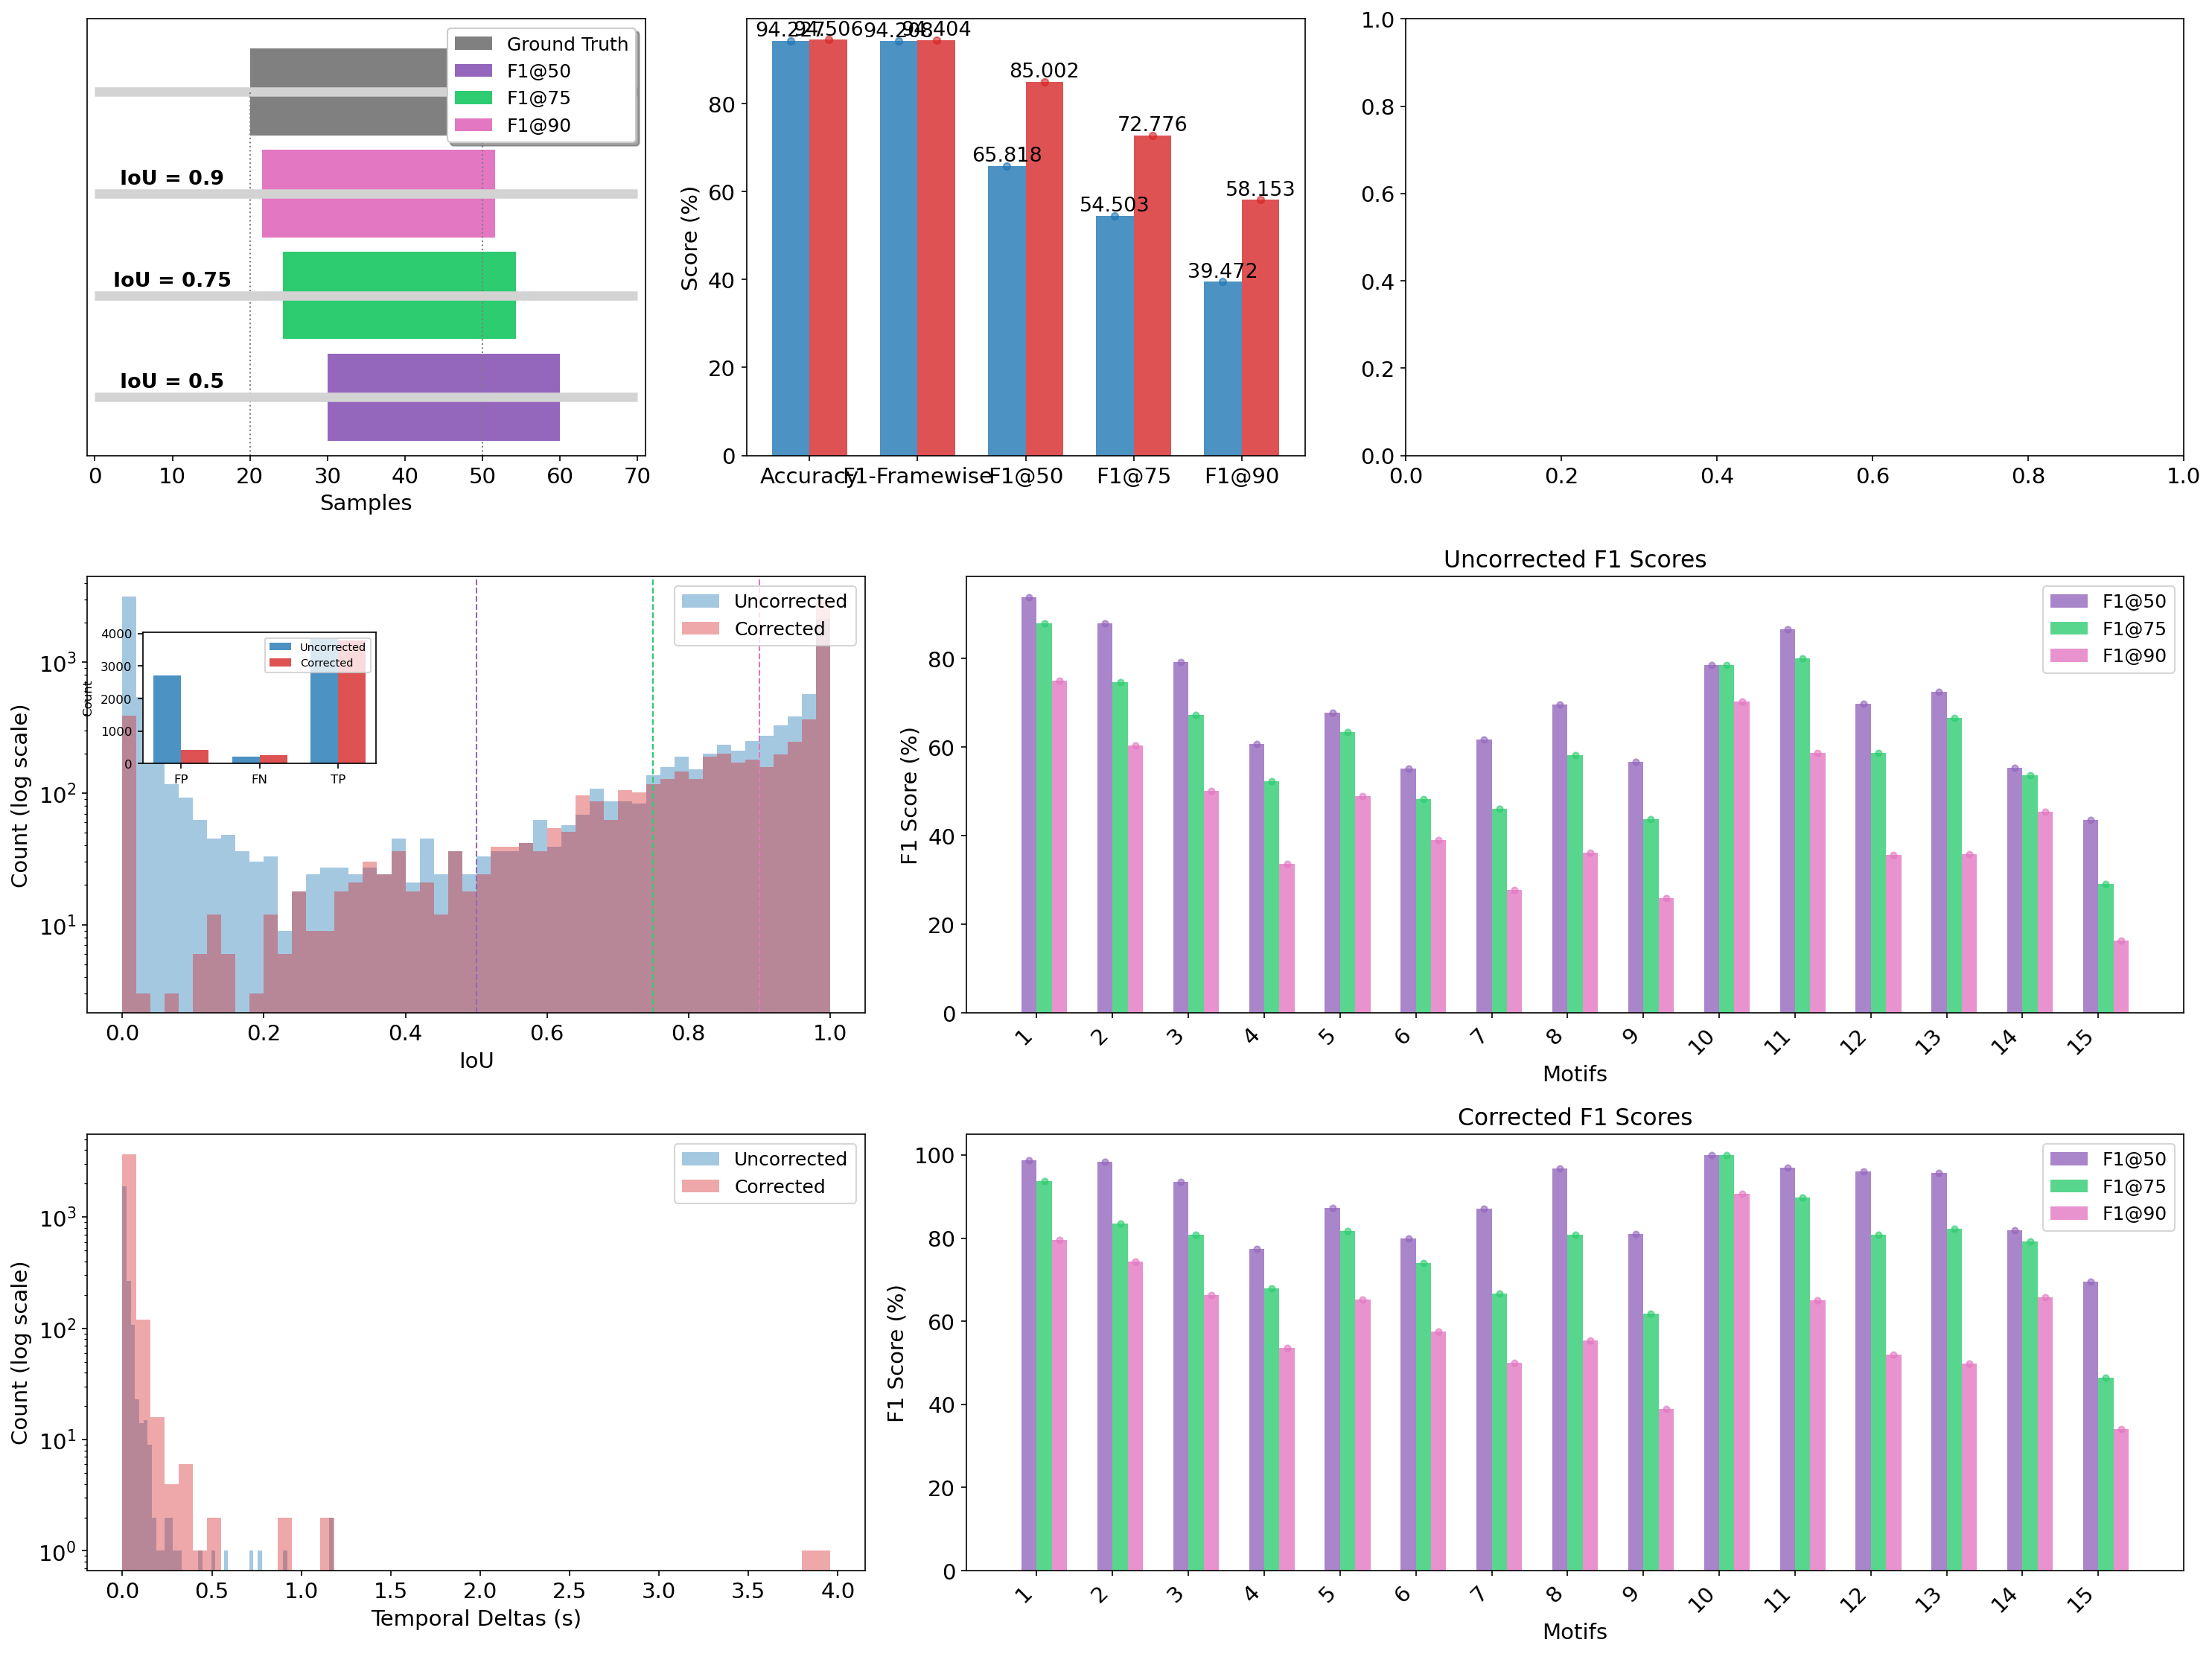

In [3]:
from ethograph.eval.eval_plotting import plot_metrics_best_model
import numpy as np
from pathlib import Path


base_dir = Path(r"C:\Users\FM\Documents\Akseli\Code\MovFormer\result\Freddy_CV_20251102_113700")
paths = sorted([str(p) for p in base_dir.iterdir() if p.is_dir()])


figs = r"C:\Users\FM\Documents\Akseli\Code\MovFormer\movformer\temp"
plot_metrics_best_model(figs, paths, f1_thresholds=[0.5, 0.75, 0.9], fps=200, epoch=40) # opening these .npy files sometimes corrupts them, watch out!

In [5]:
import numpy as np
from scipy.stats import f_oneway

# Collect all trials

from ethograph.utils.io import TrialTree
import numpy as np
import matplotlib.pyplot as plt
from ethograph.utils.labels import plot_motif_segments, load_motif_mapping


paths = [
      r"C:\Users\FM\Desktop\trainFreddy\Trial_data2601.nc",
      r"C:\Users\FM\Desktop\trainFreddy\Trial_data2701.nc",
      r"C:\Users\FM\Desktop\trainFreddy\Trial_data2702.nc",
      r"C:\Users\FM\Desktop\trainFreddy\Trial_data2801.nc",
]
trial_data = []
for path in paths:
    dt = TrialTree.load(path)


    for trial in dt.trials:
        ds = dt.sel(trials=trial)
        s3d = ds.s3d.values
        
        
        labels = ds.labels.values.squeeze()  # replace with actual label field
        if np.all(labels == 0):
            continue
        
        trial_data.append((s3d, labels))

def cohens_d_feature_selection(s3d, labels):
    """
    Calculate Cohen's d for each feature and each label.
    Returns the maximum Cohen's d across all labels for each feature.
    """
    n_features = s3d.shape[1]
    unique_labels = np.unique(labels)
    n_labels = len(unique_labels)
    
    # Matrix to store Cohen's d for each feature-label pair
    cohens_d_matrix = np.zeros((n_features, n_labels))
    
    if len(unique_labels) < 2:
        return np.zeros(n_features), cohens_d_matrix, unique_labels
    
    for feat_idx in range(n_features):
        # Skip if all values are zero
        if np.all(s3d[:, feat_idx] == 0):
            continue
        
        feature_values = s3d[:, feat_idx]
        
        for label_idx, target_label in enumerate(unique_labels):
            # Split into during label vs not during label
            during_label = feature_values[labels == target_label]
            not_during_label = feature_values[labels != target_label]
            
            if len(during_label) > 0 and len(not_during_label) > 0:
                # Calculate means
                mean_during = np.mean(during_label)
                mean_not = np.mean(not_during_label)
                
                # Calculate variances (sample variance with ddof=1)
                var_during = np.var(during_label, ddof=1) if len(during_label) > 1 else 0
                var_not = np.var(not_during_label, ddof=1) if len(not_during_label) > 1 else 0
                
                # Pooled standard deviation
                pooled_variance = (var_during + var_not) / 2
                pooled_std = np.sqrt(pooled_variance)
                
                # Cohen's d
                if pooled_std > 0:
                    cohens_d = abs(mean_during - mean_not) / pooled_std
                    cohens_d_matrix[feat_idx, label_idx] = cohens_d
    
    # For each feature, take the maximum Cohen's d across all labels
    max_cohens_d = np.max(cohens_d_matrix, axis=1)
    
    return max_cohens_d, cohens_d_matrix, unique_labels


def analyze_with_cohens_d(trial_list):
    """
    Run Cohen's d analysis across all trials.
    """
    n_trials = len(trial_list)
    n_features = 1024
    
    # Get all unique labels across all trials
    all_labels = set()
    for _, labels in trial_list:
        all_labels.update(np.unique(labels))
    label_names = np.array(sorted(all_labels))
    n_labels = len(label_names)
    
    # Store results for each trial
    per_trial_max_d = np.zeros((n_trials, n_features))
    per_trial_d_matrix = np.zeros((n_trials, n_features, n_labels))
    
    for trial_idx, (s3d, labels) in enumerate(trial_list):
        print(f"Processing trial {trial_idx+1}/{n_trials}...", end='\r')
        
        max_d, d_matrix, trial_labels = cohens_d_feature_selection(s3d, labels)
        per_trial_max_d[trial_idx] = max_d
        
        # Map trial labels to global label indices
        for i, label in enumerate(trial_labels):
            label_global_idx = np.where(label_names == label)[0][0]
            per_trial_d_matrix[trial_idx, :, label_global_idx] = d_matrix[:, i]
    
    print()
    
    # Aggregate across trials
    mean_max_d = np.mean(per_trial_max_d, axis=0)
    mean_d_matrix = np.mean(per_trial_d_matrix, axis=0)
    
    return mean_max_d, mean_d_matrix, per_trial_max_d, label_names


def get_top_50_cohens_d(mean_max_d, mean_d_matrix, label_names, top_k=50):
    """
    Get top 50 features by Cohen's d.
    """
    # Sort by mean maximum Cohen's d
    top_50_indices = np.argsort(mean_max_d)[-top_k:][::-1]
    
    print("="*70)
    print("TOP 50 FEATURES BY COHEN'S D")
    print("="*70)
    print(f"\nTop 50 feature indices:")
    print(top_50_indices)
    
    print(f"\n{'Rank':<6}{'Feature':<10}{'Max d':<12}{'Best Label':<15}{'Label d':<10}")
    print("-"*70)
    
    for rank, feat_idx in enumerate(top_50_indices[:30], 1):  # Show top 30 in detail
        max_d = mean_max_d[feat_idx]
        best_label_idx = np.argmax(mean_d_matrix[feat_idx])
        best_label = label_names[best_label_idx]
        label_d = mean_d_matrix[feat_idx, best_label_idx]
        
        print(f"{rank:<6}{feat_idx:<10}{max_d:<12.3f}{best_label:<15}{label_d:<10.3f}")
    
    return top_50_indices





def show_label_specific_breakdown(mean_d_matrix, label_names, top_50_indices):
    """
    Show which labels each top feature is selective for.
    """
    print("\n" + "="*70)
    print("LABEL-SPECIFIC BREAKDOWN FOR TOP 50 FEATURES")
    print("="*70)
    
    for label_idx, label in enumerate(label_names):
        # Get features that are most selective for this label
        label_scores = mean_d_matrix[:, label_idx]
        top_for_this_label = [f for f in top_50_indices if label_scores[f] > 0.5]
        
        print(f"\nLabel {label}: {len(top_for_this_label)} features with d > 0.5")
        
        # Show top 10 for this label
        sorted_features = sorted(top_for_this_label, key=lambda f: label_scores[f], reverse=True)[:10]
        for feat in sorted_features:
            print(f"  Feature {feat:4d}: d = {label_scores[feat]:.3f}")

# ============================================
# MAIN EXECUTION
# ============================================

print("Running Cohen's d feature selection across all trials...\n")

# # Run analysis
mean_max_d, mean_d_matrix, per_trial_max_d, label_names = analyze_with_cohens_d(trial_data)


Running Cohen's d feature selection across all trials...

Processing trial 544/544...


Duplicate key in file 'C:\\Users\\FM\\Documents\\Akseli\\Code\\MovFormer\\configs_global\\style.mplstyle', line 10 ('font.size: 13')

Bad key text.fontsize in file C:\Users\FM\Documents\Akseli\Code\MovFormer\configs_global\style.mplstyle, line 16 ('text.fontsize: 10')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.6/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


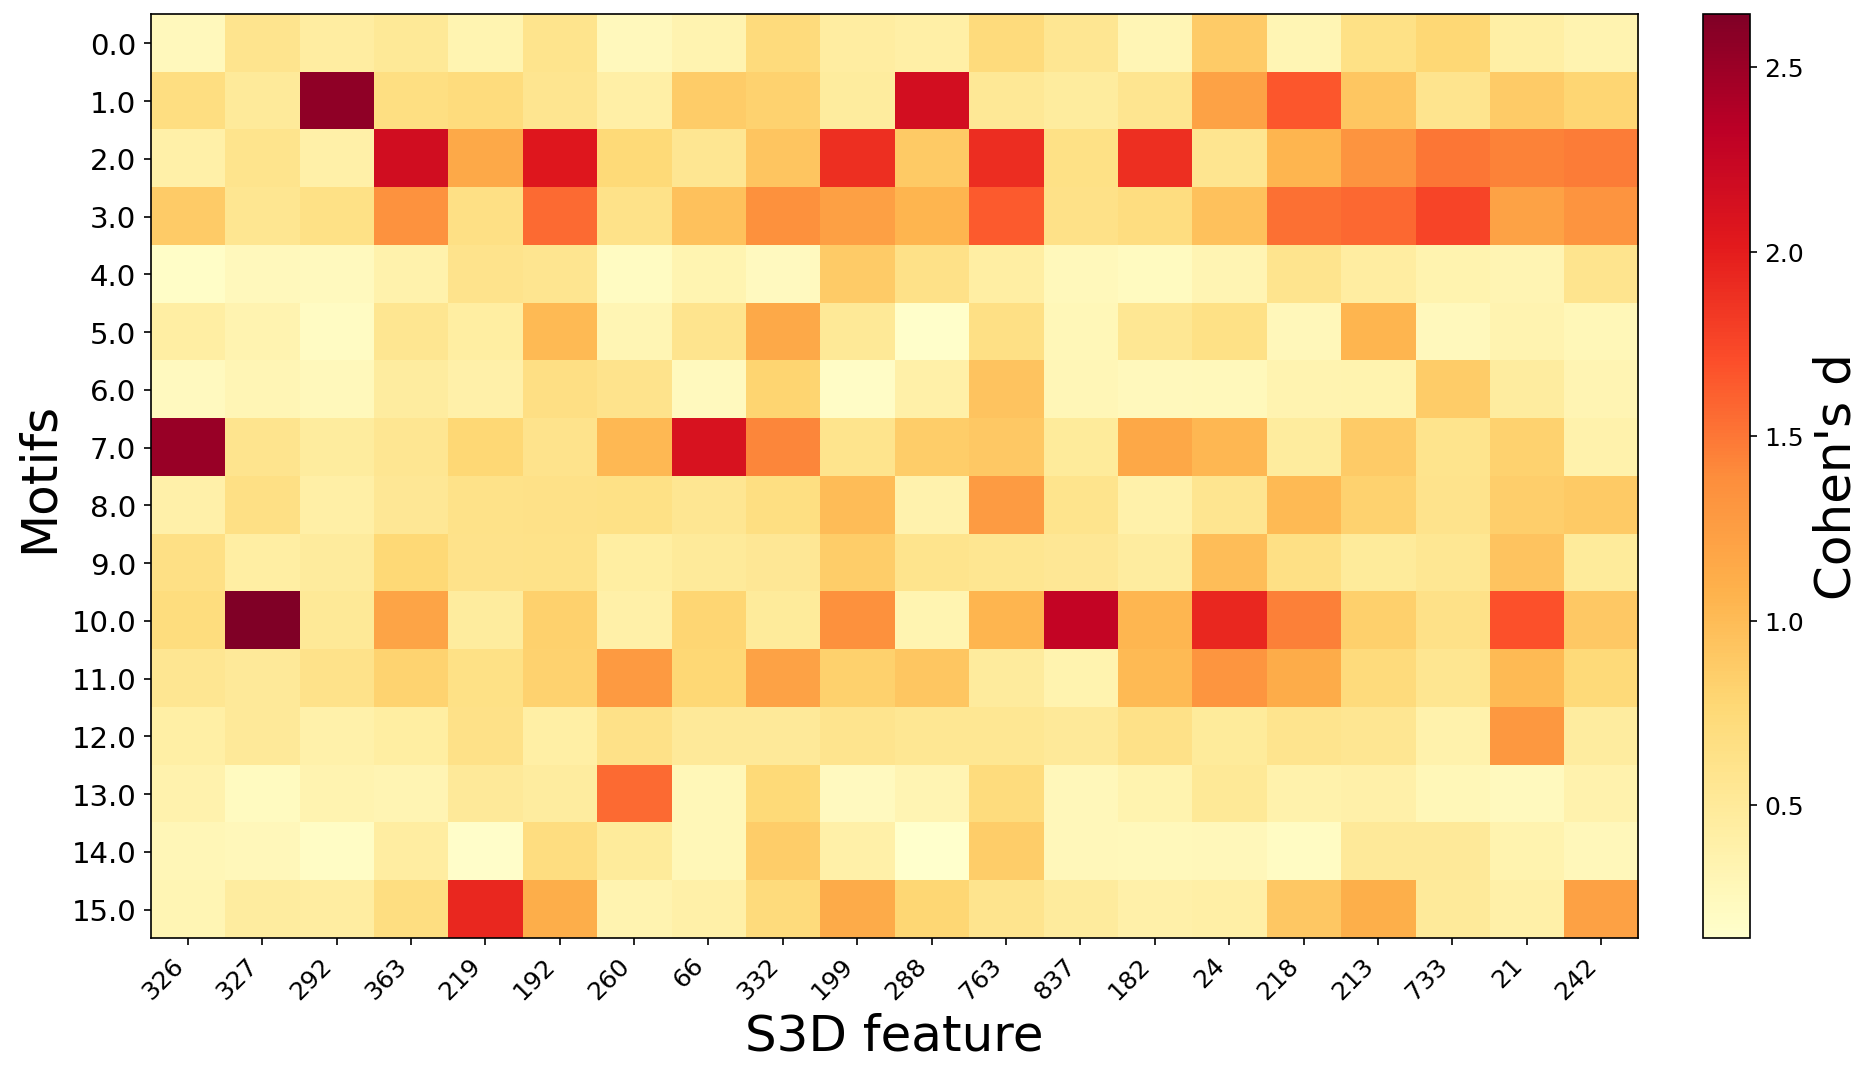

In [8]:
import matplotlib.pyplot as plt

path = r"C:\Users\FM\Documents\Akseli\Code\MovFormer\configs_global\style.mplstyle"
plt.style.use(path)

top_k = 20
top_indices = np.argsort(mean_max_d)[-top_k:][::-1]

fig, ax = plt.subplots(figsize=(14, 8))

heatmap_data = mean_d_matrix[top_indices[:top_k], :].T
im = ax.imshow(heatmap_data, aspect='auto', cmap='YlOrRd', interpolation='nearest')

ax.set_xlabel('S3D feature', fontsize=24)
ax.set_ylabel('Motifs', fontsize=24)

ax.set_yticks(range(len(label_names)))
ax.set_yticklabels(label_names, fontsize=14)

x_ticks = range(top_k)
ax.set_xticks(x_ticks)
ax.set_xticklabels([top_indices[i] for i in x_ticks], rotation=45, ha='right', fontsize=12)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Cohen's d", fontsize=24)
cbar.ax.tick_params(labelsize=12)

plt.savefig(
    "C:\\Users\\FM\\Documents\\Akseli\\Code\\MovFormer\\movformer\\thesis_figures\\accel\\cohens_d_results.eps",
    dpi=300,
    format='eps',
    bbox_inches='tight'
)
plt.show()
# # Get top 70
# top_50 = get_top_50_cohens_d(mean_max_d, mean_d_matrix, label_names, top_k=20)

# # Show label-specific breakdown
# show_label_specific_breakdown(mean_d_matrix, label_names, top_50)


# good_s3d_feats = [
#     326, 327, 292, 363, 219, 192, 260, 66, 332, 199,
#     288, 763, 837, 182, 24, 218, 213, 21, 733, 242
# ]

No auxiliary file found for trial 1: C:\Users\FM\Desktop\aux_data\Freddy_20250527_01_trial001_v_aux_speed.npy
No auxiliary file found for trial 2: C:\Users\FM\Desktop\aux_data\Freddy_20250527_01_trial002_v_aux_speed.npy
No auxiliary file found for trial 3: C:\Users\FM\Desktop\aux_data\Freddy_20250527_01_trial003_v_aux_speed.npy
No auxiliary file found for trial 4: C:\Users\FM\Desktop\aux_data\Freddy_20250527_01_trial004_v_aux_speed.npy
No auxiliary file found for trial 5: C:\Users\FM\Desktop\aux_data\Freddy_20250527_01_trial005_v_aux_speed.npy
No auxiliary file found for trial 6: C:\Users\FM\Desktop\aux_data\Freddy_20250527_01_trial006_v_aux_speed.npy
No auxiliary file found for trial 7: C:\Users\FM\Desktop\aux_data\Freddy_20250527_01_trial007_v_aux_speed.npy
No auxiliary file found for trial 8: C:\Users\FM\Desktop\aux_data\Freddy_20250527_01_trial008_v_aux_speed.npy
No auxiliary file found for trial 9: C:\Users\FM\Desktop\aux_data\Freddy_20250527_01_trial009_v_aux_speed.npy
No auxilia

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


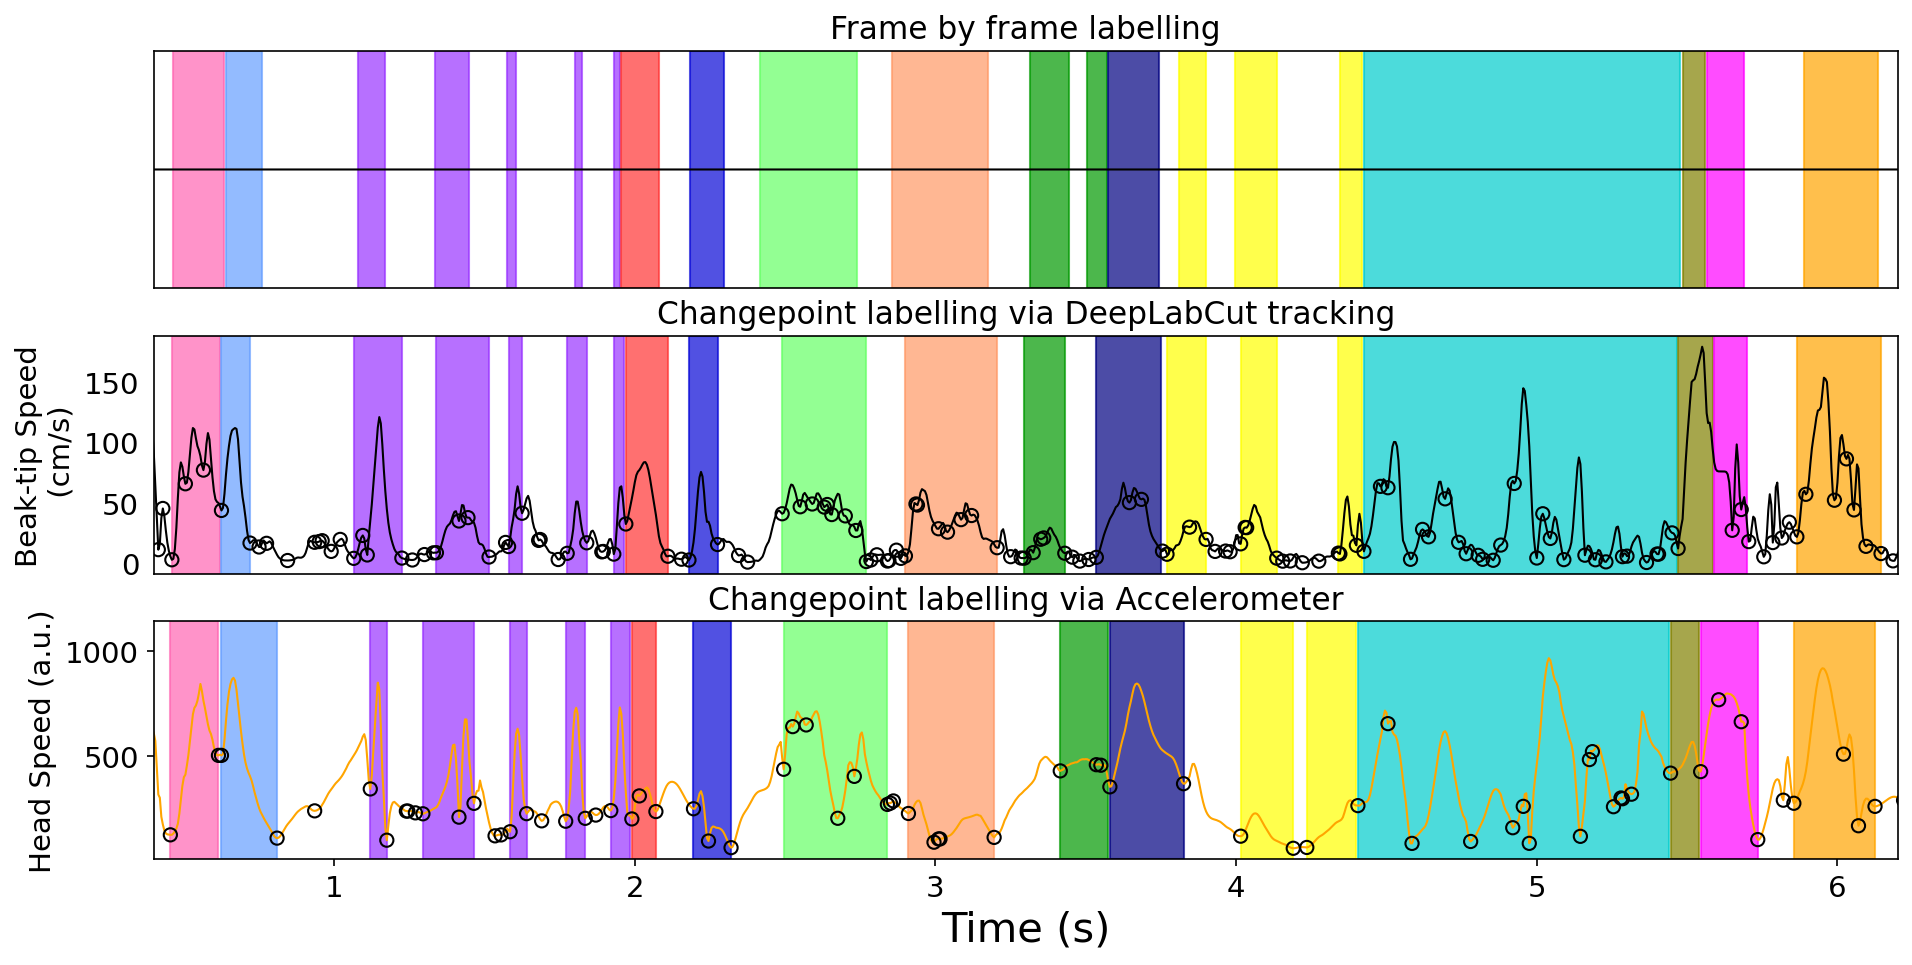

In [25]:

from ethograph.utils.io import TrialTree, add_changepoints_to_ds
from ethograph.features.changepoints import find_nearest_turning_points_binary, find_troughs_binary
import numpy as np
import os
from movement.utils.vector import compute_norm
from ethograph.features.preprocessing import gaussian_smoothing

path2 = r"C:\Users\FM\Desktop\trainFreddy\Trial_data2701.nc"
dt = TrialTree.load(path2)
path = r"C:\Users\FM\Desktop\aux_data"
smoothing_params = {"sigma": 1.5, "axis": 0, "mode": "constant", "cval": np.nan}

# Add auxiliary speed data to each trial
for trial in dt.trials[:20]:
    aux_filename = f"Freddy_20250527_01_trial{trial:03d}_v_aux_speed.npy"
    aux_filename2 = f"Freddy_20250527_01_trial{trial:03d}_a_aux_trial_driftcorr.npy"
    aux_file = os.path.join(path, aux_filename)
    
    if os.path.exists(aux_file):
        speed_aux = np.load(aux_file)
        speed_aux = speed_aux.squeeze()
        time_aux = np.arange(len(speed_aux)) / 30000  # Assuming 30 kHz sampling rate
        
        time = dt.sel(trials=trial).time.values
        N = len(time)
        
        speed_aux_interp = np.interp(time, time_aux, speed_aux)
        accel_aux = np.load(os.path.join(path, aux_filename2))

        accel_aux_interp = np.zeros((N, 3))
        
        for i in range(accel_aux.shape[1]):
            accel_aux_interp[:, i] = np.interp(time, time_aux, accel_aux[:, i])
            
            


        # Access the DataTree node directly
        trial_node = dt[f"trial_{trial}"]
        ds = trial_node.ds.copy()
        ds["accel_aux_driftcorr"] = (('time', 'space'), accel_aux_interp)
        ds["accel_aux_driftcorr"].attrs['type'] = 'features'
        
        
        norm = compute_norm(ds["accel_aux_driftcorr"])
        norm_smooth = gaussian_smoothing(norm, **smoothing_params)
        
        ds["accel_aux_norm"] = (('time',), norm_smooth.data)
        ds["accel_aux_norm"].attrs['type'] = 'features'
        
        
        ds['speed_aux'] = (('time',), speed_aux_interp)
        ds["speed_aux"].attrs['type'] = 'features' 
        
        
        ds = add_changepoints_to_ds(
            ds=ds, 
            target_feature="speed_aux",
            changepoint_name="troughs", 
            changepoint_func=find_troughs_binary, 
            prominence=0.5, 
            distance=2
        )
      
        ds = add_changepoints_to_ds(
                ds=ds,
                target_feature="speed_aux",
                changepoint_name="turning_points",
                changepoint_func=find_nearest_turning_points_binary,
                max_value=300,
                prominence=3,
                width=2)
        
        ds = add_changepoints_to_ds(
            ds=ds, 
            target_feature="accel_aux_norm",
            changepoint_name="troughs", 
            changepoint_func=find_troughs_binary, 
            distance=2
        )
      
        ds = add_changepoints_to_ds(
                ds=ds,
                target_feature="accel_aux_norm",
                changepoint_name="turning_points",
                changepoint_func=find_nearest_turning_points_binary,
                threshold=0.3,
                width=2,
                max_value=0.1,
                prominence=0.1
                )

        
        trial_node.ds = ds
    else:
        print(f"No auxiliary file found for trial {trial}: {aux_file}")


dt.to_netcdf(r"C:\Users\FM\Desktop\trainFreddy\Trial_data2701_with_aux_speed.nc")


from ethograph.utils.labels import load_motif_mapping,plot_motif_segments
from ethograph.features.changepoints import merge_changepoints
from ethograph.utils.io import TrialTree
import matplotlib.pyplot as plt
import numpy as np
def get_time_labels(dt, trial_num):
    time = dt.sel(trials=trial_num).time.values
    labels = dt.sel(trials=trial_num).labels.squeeze().values
    return time, labels

motif_mappings = load_motif_mapping(r"C:\Users\FM\Documents\Akseli\Code\MovFormer\configs_global\mapping.txt")
path = r"C:\Users\FM\Desktop\accelerometer\Trial_data2701_with_AUX_data.nc"
path2 = r"C:\Users\FM\Desktop\accelerometer\Trial_data2701_labels_speed_AUX.nc"
path3 = r"C:\Users\FM\Desktop\accelerometer\Trial_data2701_labels_framebyframeLabelling.nc"
path4 = r"C:\Users\FM\Desktop\accelerometer\Trial_data2701_labels_speed_DLC.nc"


dt1 = TrialTree.load(path)
dt2 = TrialTree.load(path2)
dt3 = TrialTree.load(path3)
dt4 = TrialTree.load(path4)

trial = 6
tp = dt1.sel(trials=trial).speed_turning_points.sel(keypoints="beakTip").squeeze().values
trough = dt1.sel(trials=trial).speed_troughs.sel(keypoints="beakTip").squeeze().values
cp_idxs = np.where((tp == 1) | (trough == 1))[0]
cp_idxs


tp = dt1.sel(trials=trial).speed_aux_turning_points.squeeze().values
trough = dt1.sel(trials=trial).speed_aux_troughs.squeeze().values
cp_idxs2 = np.where((tp == 1) | (trough == 1))[0]
cp_idxs2




speed = dt1.sel(trials=trial).speed.sel(keypoints="beakTip").squeeze().values
speed_aux = dt1.sel(trials=trial).speed_aux.squeeze().values
time = dt1.sel(trials=trial).time.values

figure, ax = plt.subplots(3, 1, figsize=(15, 7), sharex=True)
ax[0].plot(time, np.ones(len(time)), color="k")
time, labels = get_time_labels(dt3, trial)
plot_motif_segments(ax[0], time, labels, motif_mappings)
ax[0].set_title("Frame by frame labelling")
ax[0].tick_params(left=False, bottom=False)
ax[0].set_yticks([])
ax[0].set_ylabel("")

ax[1].plot(time, speed, color="k")
ax[1].tick_params(left=False, bottom=False)
ax[1].scatter(time[cp_idxs], speed[cp_idxs], s=40, marker='o',
                            edgecolor='black', facecolor='none', zorder=4)
time, labels = get_time_labels(dt4, trial)
ax[1].set_title("Changepoint labelling via DeepLabCut tracking")
ax[1].set_ylabel("Beak-tip Speed\n (cm/s)")

plot_motif_segments(ax[1], time, labels, motif_mappings)
ax[2].plot(time, speed_aux, color="orange")
ax[2].scatter(time[cp_idxs2], speed_aux[cp_idxs2], s=40, marker='o',
                            edgecolor='black', facecolor='none', zorder=4)
time, labels = get_time_labels(dt2, trial)
ax[2].set_title("Changepoint labelling via Accelerometer")
ax[2].set_ylabel("Head Speed (a.u.)")
plot_motif_segments(ax[2], time, labels, motif_mappings)
plt.xlim(0.4, 6.2)
plt.xlabel("Time (s)", fontsize=20)


plt.savefig("C:\\Users\\FM\\Documents\\Akseli\\Code\\MovFormer\\movformer\\thesis_figures\\accel\\dlc_accel_comparison.eps")